In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
df = pd.read_csv("/home/pedro/Documents/BIA/p3/PAD/trabalho-final/deteccao-de-fraude/data/creditcard_treated.csv", index_col=0)

In [3]:
class_label = df.Class
df = df.drop(columns=['Class'])

Aplicamos o KMeans com 3 clusters e random_state de 434, pois esses são os melhores valores que os nossos colegas acharam em codigos anteriores.

In [4]:
# Aplicar KMeans com 3 clusters (que os nossos colegas descobriram)
kmeans = KMeans(n_clusters=3, random_state=434)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=434)

Vamos calcular as distancias de cada ponto ate o seu respectivo cluster, e normalizar essa distancia para facilitar quando usarmos uma DNN.

In [5]:
# Calcular a distância de cada ponto ao centro do cluster correspondente
centers = kmeans.cluster_centers_
distances = np.linalg.norm(df - centers[kmeans.labels_], axis=1)
# Normalizar as distâncias
distances_scaled = StandardScaler().fit_transform(distances.reshape(-1, 1))

Organizamos o dataset

In [6]:

# Adicionar as labels do cluster à tabela
df['Cluster'] = kmeans.labels_

# Adicionar a distância à tabela
df['Distance_to_Center'] = distances_scaled

# Adicionar as classes novamente
df['Class'] = class_label
df = df.drop(columns=['Time','Amount'])

display(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Cluster,Distance_to_Center,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1,2.586807,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1,2.586807,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1,2.586682,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1,2.586682,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,1,2.586558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566501,-7.151786,5.337862,-10.524210,6.638176,-7.107253,-3.688276,-11.629728,4.641323,-6.040679,-13.178539,...,-0.223411,0.029599,0.393875,-0.049155,0.544700,1.306198,0.223600,1,-0.611082,1
566502,-4.705909,8.250299,-14.559164,9.787990,-4.117161,-3.169121,-10.169571,4.500750,-5.177936,-10.851427,...,0.194092,0.480124,-1.079562,-0.444215,0.557467,1.234855,0.627900,1,0.809383,1
566503,0.407366,1.352354,-4.892782,3.554728,-1.282114,-1.271505,-0.977517,0.462476,-1.442286,-3.619048,...,0.703300,0.814076,0.814930,-0.300969,0.168339,0.236775,0.037244,0,-0.498273,1
566504,0.580032,2.773047,-5.790024,5.606953,0.398480,-0.621865,-2.954884,0.837074,-1.822486,-4.602626,...,-0.810361,-0.067584,-0.632356,0.414552,0.073243,0.736440,0.358067,2,2.232127,1


# Visualização Rapida
---

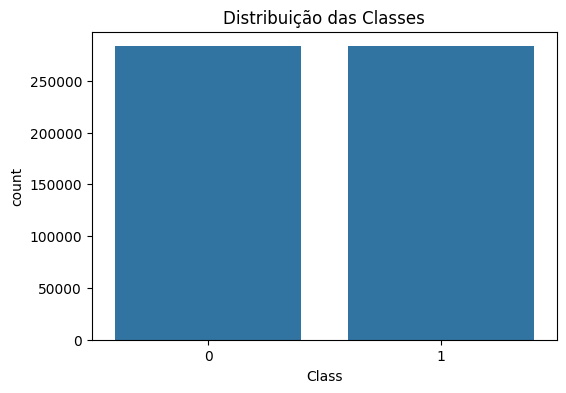

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição das classes
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Distribuição das Classes')
plt.show()

Por conta do SMOTE temos o meus numero de fraude e transações normais

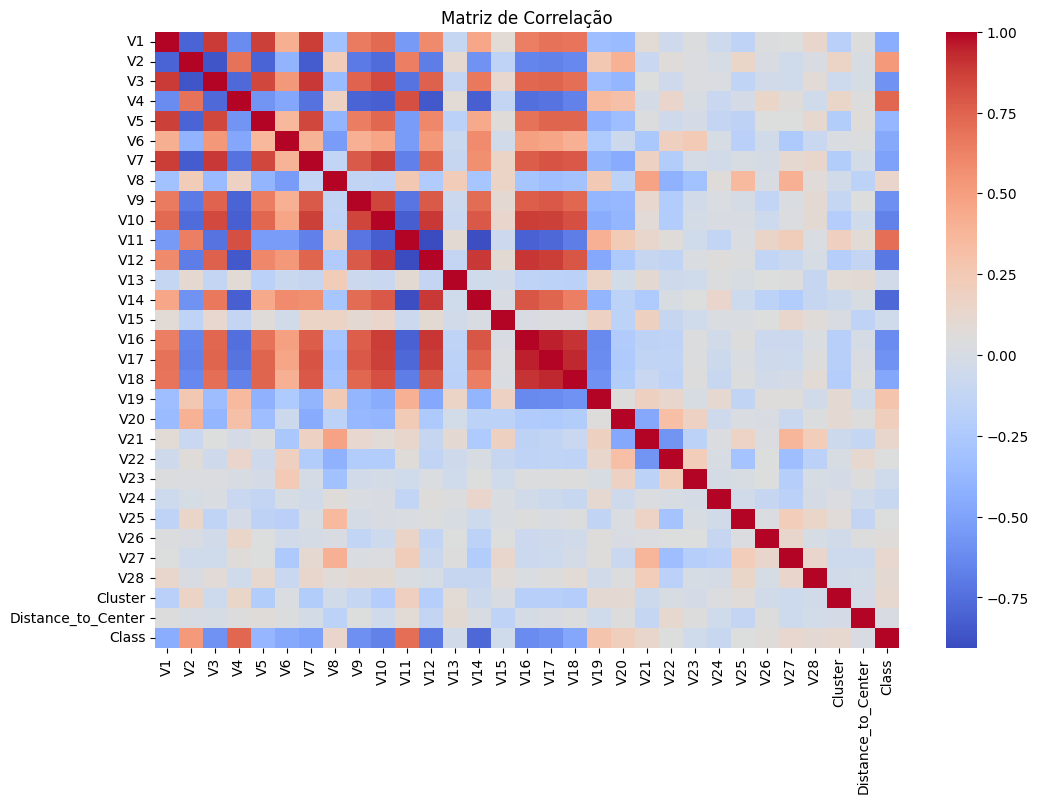

In [8]:
# Visualizar correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de Correlação')
plt.show()

Podemos ver que os dados possuem uma boa matriz de correlação

---
## Vamos para o VAE agora

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


In [43]:
X = df.drop(columns=['Class'])
y = df['Class']

Vamos dividir os dados em 40% de treino, 30% de teste e 30% de verificação. 

In [44]:
# Dividir os dados em treino, teste e validação
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Defimos no Keras, um modelo Sequencial de rede neural profunda, com 2 hidden layers de relu, uma sigmoid ao final.


In [45]:
input_dim = X_train.shape[1]
latent_dim = 2  # Dimensão do espaço latente

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(64, activation='relu')(inputs)
h = Dense(32, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


In [46]:

# Reparametrização
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [47]:
# Decoder
decoder_h = Dense(32, activation='relu')
decoder_h2 = Dense(64, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

In [49]:
# Definir o modelo encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Definir o modelo decoder
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h2(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean, name='decoder')

# Função de perda
@tf.function
def vae_loss(inputs, x_decoded_mean, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(inputs, x_decoded_mean) * input_dim
    kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Adicionando a perda ao modelo
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        x_decoded_mean = self.decoder(z)
        loss = vae_loss(inputs, x_decoded_mean, z_mean, z_log_var)
        self.add_loss(loss)
        return x_decoded_mean

# Criando o modelo VAE completo
vae = VAEModel(encoder, decoder)
vae.compile(optimizer='adam')
#vae.summary()


In [52]:
# Treinamento do VAE
history = vae.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_val, X_val))


Epoch 1/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -607.0616 - val_loss: -615.1670
Epoch 2/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -610.3604 - val_loss: -615.4019
Epoch 3/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -605.8983 - val_loss: -614.7389
Epoch 4/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -607.7112 - val_loss: -615.8467
Epoch 5/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -607.3359 - val_loss: -615.6783
Epoch 6/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -608.7834 - val_loss: -615.8060
Epoch 7/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -609.9198 - val_loss: -615.8373
Epoch 8/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -607.9285 - val_loss: -616.2893
Epoch 9/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -607.9449 - val_loss: -616.6736
Epoch 10/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: -608.9490 - val_loss: -616.6385
Epoch 11/50
2656/2656 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - lo

## Visualizacao

6197/6197 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


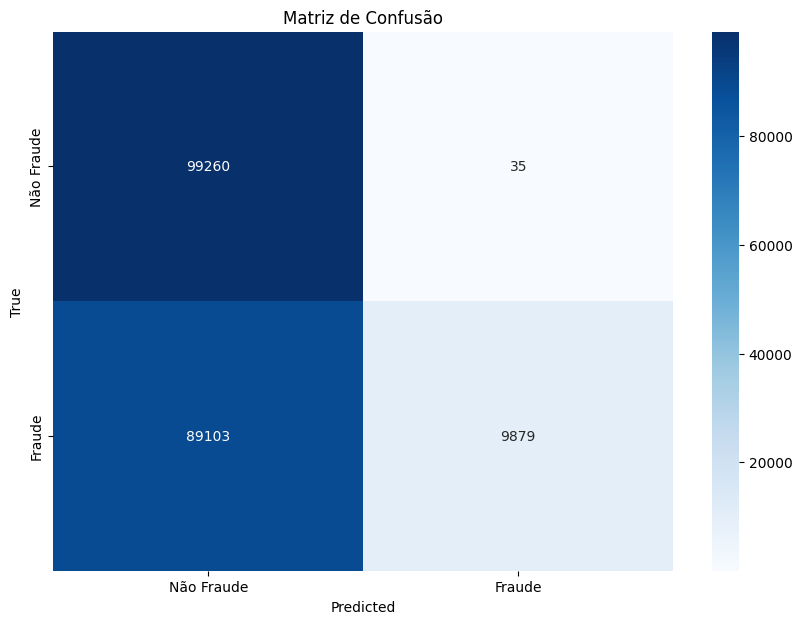

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69     99295
           1       1.00      0.10      0.18     98982

    accuracy                           0.55    198277
   macro avg       0.76      0.55      0.44    198277
weighted avg       0.76      0.55      0.44    198277



In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Decodificar os dados de teste
decoded_test = vae.predict(X_test)

# Calcular o erro de reconstrução
reconstruction_error = np.mean(np.power(X_test - decoded_test, 2), axis=1)

# Definir um limiar para classificação
threshold = np.percentile(reconstruction_error, 95)

# Classificar os pontos como anomalias ou não
y_pred = (reconstruction_error > threshold).astype(int)

# Avaliar a performance
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Fraude', 'Fraude'], yticklabels=['Não Fraude', 'Fraude'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

# Exibir o relatório de classificação
print("Relatório de Classificação:\n", report)
